In [1]:
# !pip install pandas

In [2]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Input
from tensorflow.keras.callbacks import EarlyStopping

2025-10-30 12:38:23.957446: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-30 12:38:23.981932: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-30 12:38:23.981945: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-30 12:38:23.981961: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-30 12:38:23.986562: I tensorflow/core/platform/cpu_feature_g

## Carga de los datos

In [3]:
df = pd.read_csv("datos.csv",parse_dates=['timestamp'])

print("Informacion del dataset\n")
print(df)
print(df.shape)
print(df.describe())

Informacion del dataset

               timestamp      value
0    2013-07-04 00:00:00  69.880835
1    2013-07-04 01:00:00  71.220227
2    2013-07-04 02:00:00  70.877805
3    2013-07-04 03:00:00  68.959400
4    2013-07-04 04:00:00  69.283551
...                  ...        ...
7262 2014-05-28 11:00:00  72.370206
7263 2014-05-28 12:00:00  72.172956
7264 2014-05-28 13:00:00  72.046565
7265 2014-05-28 14:00:00  71.825226
7266 2014-05-28 15:00:00  72.584089

[7267 rows x 2 columns]
(7267, 2)
                           timestamp        value
count                           7267  7267.000000
mean   2013-12-17 01:43:01.477914112    71.242433
min              2013-07-04 00:00:00    57.458406
25%              2013-10-01 13:30:00    68.369411
50%              2013-12-19 04:00:00    71.858493
75%              2014-03-06 01:30:00    74.430958
max              2014-05-28 15:00:00    86.223213
std                              NaN     4.247509


## Visualización de los datos

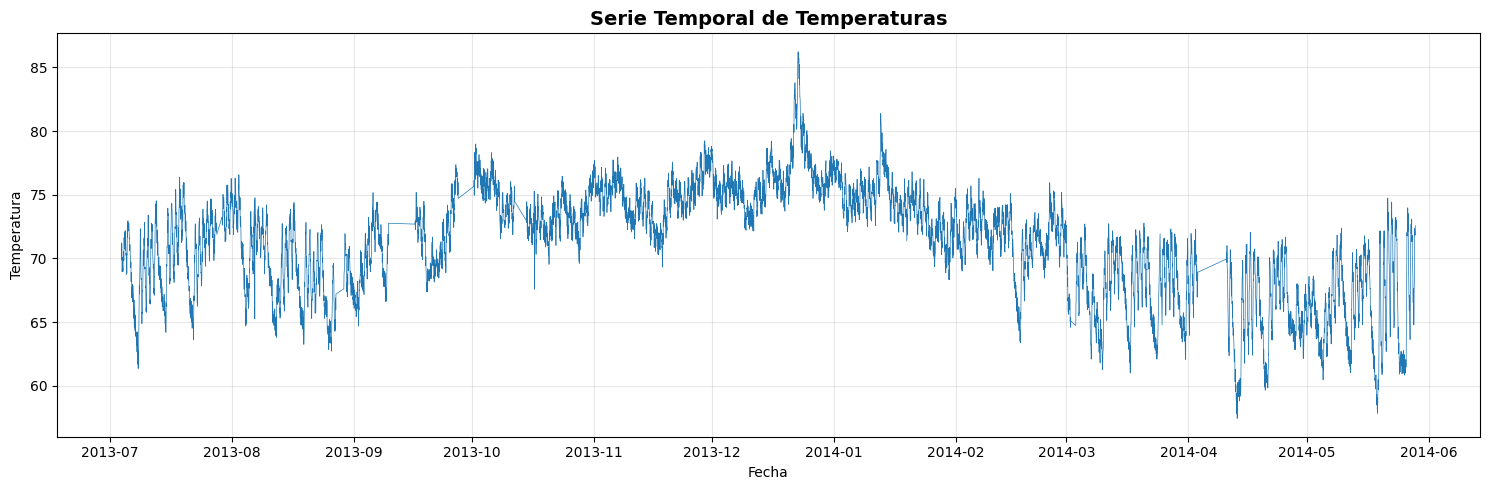

In [4]:

plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['value'], linewidth=0.5)
plt.title('Serie Temporal de Temperaturas', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# LSTM y detección de anomalías

## 1.a) Construcción de modelo básico

### Preparación de los datos para el entrenamiento
Vamos a construirlo con tamaño de ventana 3 y una sola feature

In [5]:
def create_sequence(data, window_size, n_features):
    windows = np.lib.stride_tricks.sliding_window_view(data, window_shape=window_size)
    X = array(windows[:-1])
    y = array(data[window_size:])
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

window_size_basic = 3
n_features = 1
raw_temp = df["value"].values
X, y = create_sequence(raw_temp, window_size_basic, n_features)
X = X.reshape((X.shape[0], X.shape[1],n_features))
print(X.shape)
print(y.shape)

(7264, 3, 1)
(7264,)


### Contrucción del modelo LSTM básico

In [6]:
def build_basic_lstm_model(window_size, lstm_units=50):
    model = Sequential([
        LSTM(lstm_units, activation='relu', input_shape=(window_size, 1)),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

model_basic = build_basic_lstm_model(window_size_basic)
model_basic.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2025-10-30 12:38:25.079152: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: UNKNOWN ERROR (34)


### Entrenamiento del modelo básico
Vamos a entrarlo con 30 épocas.

In [7]:
# definimoos un early stop para parar si se llega a un valor de perdida buscado
print("Entrenando modelo básico...")
history_basic = model_basic.fit(
    X, y,
    epochs=30,
    batch_size=32,
    validation_data=(X, y),
    verbose=1
)

print("Entrenamiento completado")

Entrenando modelo básico...
Epoch 1/30
227/227 [==============================] - 1s 2ms/step - loss: 366.4214 - mae: 8.1525 - val_loss: 1.1077 - val_mae: 0.8175
Epoch 2/30
227/227 [==============================] - 0s 1ms/step - loss: 1.0995 - mae: 0.8089 - val_loss: 1.0931 - val_mae: 0.8083
Epoch 3/30
227/227 [==============================] - 0s 1ms/step - loss: 1.0963 - mae: 0.8082 - val_loss: 1.0879 - val_mae: 0.8042
Epoch 4/30
227/227 [==============================] - 0s 1ms/step - loss: 1.0944 - mae: 0.8082 - val_loss: 1.0859 - val_mae: 0.8021
Epoch 5/30
227/227 [==============================] - 0s 1ms/step - loss: 1.0976 - mae: 0.8100 - val_loss: 1.0875 - val_mae: 0.8109
Epoch 6/30
227/227 [==============================] - 0s 1ms/step - loss: 1.0831 - mae: 0.8066 - val_loss: 1.0854 - val_mae: 0.8120
Epoch 7/30
227/227 [==============================] - 0s 1ms/step - loss: 1.0731 - mae: 0.8048 - val_loss: 1.0574 - val_mae: 0.7943
Epoch 8/30
227/227 [==========================

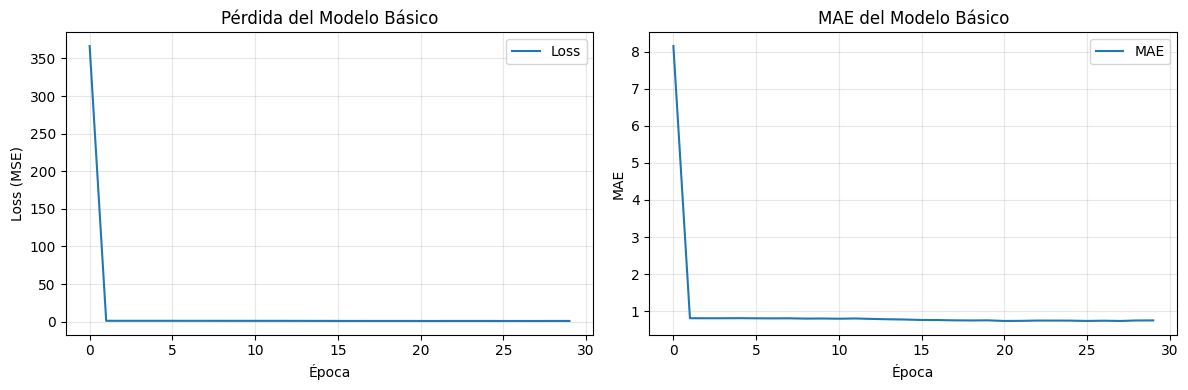

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_basic.history['loss'], label='Loss')
plt.title('Pérdida del Modelo Básico')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_basic.history['mae'], label='MAE')
plt.title('MAE del Modelo Básico')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Podemos ver como la perdida aún no se ha estabilizado pero continuaremos con estos datos. Más adelante trataremos de mejorar el modelo. Vamos a usar como detección principal un threshold del 95 porciento por lo que el 5% de valores más alejados respecto a su valor real serán los considerados anómalos.

## 1.b) Detección de Anomalías con LSTM
Trataremos los datos como anómalos si superan el percentil 95 con mayor error respecto a su valor real.

In [9]:
def detect_anomalies_lstm(model, X, y, threshold_per=95):
    predictions = model_basic.predict(X)
    errors = np.abs(predictions.flatten() - y)
    threshold = np.percentile(errors, threshold_per)
    anomalies = errors > threshold

    return predictions, errors, anomalies, threshold

predictions, errors, anomalies, threshold = detect_anomalies_lstm(model_basic, X, y)

anomaly_indices = np.where(anomalies)[0]
# registramos el primer valor de la ventana al contar toda ella como anómala.
anomaly_timestamps = df['timestamp'].iloc[anomaly_indices].values
anomaly_values = y[anomaly_indices]
print(f"Umbral de anomalía (percentil 95): {threshold}")

print(f"Número de anomalías detectadas: {np.sum(anomalies)}")
print(f"Porcentaje de anomalías: {100 * np.sum(anomalies) / len(anomalies):.2f}%\n")

print(f"El número de anomalias es {np.sum(anomalies)} sobre ({y.size})")
for timestamp, value in zip(anomaly_timestamps, anomaly_values):
    print(f"{timestamp} ({value})")


227/227 [==============================] - 0s 403us/step
Umbral de anomalía (percentil 95): 1.6831203401533161
Número de anomalías detectadas: 364
Porcentaje de anomalías: 5.01%

El número de anomalias es 364 sobre (7264)
2013-07-04T00:00:00.000000000 (68.95939994)
2013-07-05T08:00:00.000000000 (72.53056283)
2013-07-08T06:00:00.000000000 (64.44813096)
2013-07-08T09:00:00.000000000 (67.88554227)
2013-07-08T13:00:00.000000000 (70.32033392)
2013-07-08T15:00:00.000000000 (72.33830154)
2013-07-08T19:00:00.000000000 (68.88572309999999)
2013-07-09T08:00:00.000000000 (69.93367814)
2013-07-09T18:00:00.000000000 (69.72083178)
2013-07-10T07:00:00.000000000 (69.75301970000001)
2013-07-10T15:00:00.000000000 (73.40419990000002)
2013-07-11T01:00:00.000000000 (66.49549932)
2013-07-11T07:00:00.000000000 (70.51575503)
2013-07-12T01:00:00.000000000 (67.43148423)
2013-07-12T09:00:00.000000000 (71.79856679999997)
2013-07-12T10:00:00.000000000 (72.95326709)
2013-07-15T07:00:00.000000000 (68.4034625)
2013-07

### Visualización de las anomalías detectadas

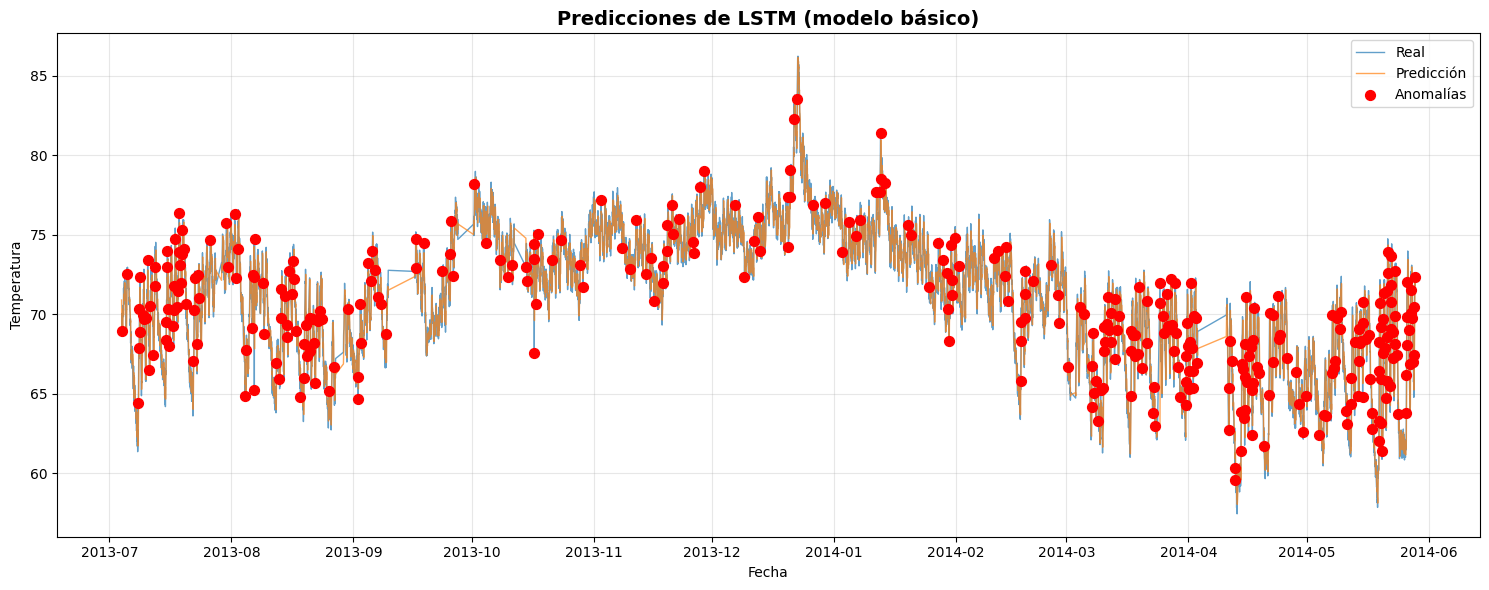

In [10]:
plt.figure(figsize=(15, 6))

timestamps = df['timestamp'].iloc[window_size_basic:].values

plt.plot(timestamps, y, label='Real', linewidth=1, alpha=0.7)
plt.plot(timestamps, predictions, label='Predicción', linewidth=1, alpha=0.7)
plt.scatter(timestamps[anomalies], y[anomalies], 
           color='red', label='Anomalías', s=50, zorder=5)

plt.title('Predicciones de LSTM (modelo básico)', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 1.c) Mejora del Modelo LSTM
Vamos a mejorar el modelo con 2 cambios.
1. Normalizaremos con MinMaxScaler consiguiendo tener los datos entre 0 y 1.
2. Añadiremos más capas, dropout y cambiaremos rango de detección.

In [11]:
# Normalizar los datos
window_size_improved = 24
scaler = MinMaxScaler(feature_range=(0, 1))
values_scaled = scaler.fit_transform(raw_temp.reshape(-1, 1)).flatten()

# Crear secuencias con datos normalizados
X_scaled, y_scaled = create_sequence(values_scaled, window_size_improved,n_features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1],n_features))


print("Datos normalizados con MinMaxScaler")
print(f"Rango original: [{raw_temp.min():.2f}, {raw_temp.max():.2f}]")
print(f"Rango escalado: [{values_scaled.min():.2f}, {values_scaled.max():.2f}]")

Datos normalizados con MinMaxScaler
Rango original: [57.46, 86.22]
Rango escalado: [0.00, 1.00]


In [12]:
def build_improved_lstm_model(window_size):
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=(window_size, 1)),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model
    
model_improved = build_improved_lstm_model(window_size_improved)

print("Arquitectura del Modelo LSTM Mejorado:")
model_improved.summary()

Arquitectura del Modelo LSTM Mejorado:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 24, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 24, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 7

In [13]:
print("Entrenando modelo LSTM mejorado...")
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_improved = model_improved.fit(
    X_scaled, y_scaled,
    epochs=50,
    batch_size=32,
    validation_data=(X_scaled, y_scaled),
    callbacks=[early_stop],
    verbose=1
)

print("\nEntrenamiento completado")

Entrenando modelo LSTM mejorado...
Epoch 1/50
227/227 [==============================] - 3s 9ms/step - loss: 0.0115 - mae: 0.0756 - val_loss: 0.0032 - val_mae: 0.0445
Epoch 2/50
227/227 [==============================] - 2s 8ms/step - loss: 0.0034 - mae: 0.0459 - val_loss: 0.0014 - val_mae: 0.0293
Epoch 3/50
227/227 [==============================] - 2s 8ms/step - loss: 0.0022 - mae: 0.0370 - val_loss: 0.0014 - val_mae: 0.0293
Epoch 4/50
227/227 [==============================] - 2s 8ms/step - loss: 0.0019 - mae: 0.0343 - val_loss: 0.0022 - val_mae: 0.0381
Epoch 5/50
227/227 [==============================] - 2s 8ms/step - loss: 0.0017 - mae: 0.0322 - val_loss: 0.0013 - val_mae: 0.0285
Epoch 6/50
227/227 [==============================] - 2s 8ms/step - loss: 0.0016 - mae: 0.0315 - val_loss: 0.0014 - val_mae: 0.0291
Epoch 7/50
227/227 [==============================] - 2s 8ms/step - loss: 0.0016 - mae: 0.0315 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 8/50
227/227 [=====================

In [14]:
predictions_improved, errors_improved, anomalies_improved, threshold_improved = detect_anomalies_lstm(
    model_improved, X_scaled, y_scaled, threshold_per=95
)

227/227 [==============================] - 0s 920us/step


In [15]:
# desnormalizamos las predicciones
predictions_improved_denorm = scaler.inverse_transform(predictions_improved.reshape(-1, 1)).flatten()

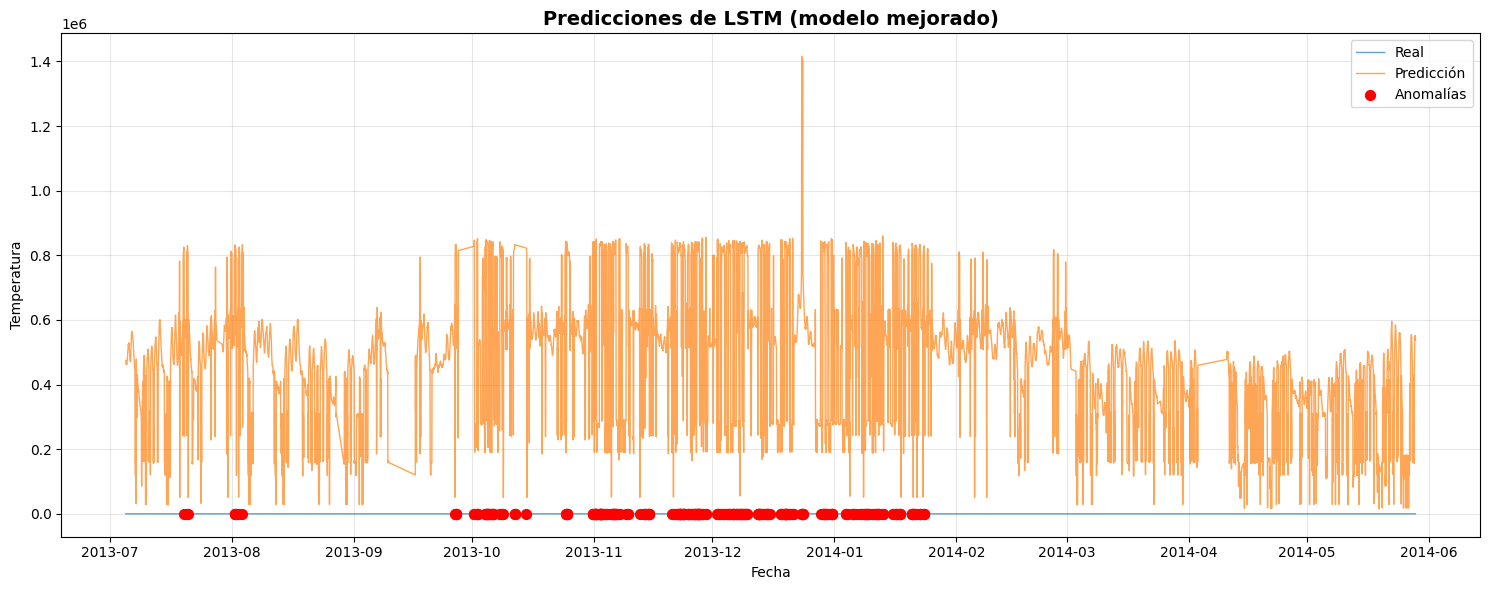

In [27]:
plt.figure(figsize=(15, 6))
timestamps_improved = df['timestamp'].iloc[window_size_improved:].values
plt.plot(timestamps_improved, y_improved_denorm, label='Real', linewidth=1, alpha=0.7)
plt.plot(timestamps_improved, predictions_improved_denorm, label='Predicción', linewidth=1, alpha=0.7)
plt.scatter(timestamps_improved[anomalies_improved], y_improved_denorm[anomalies_improved], 
           color='red', label='Anomalías', s=50, zorder=5)
plt.title('Predicciones de LSTM (modelo mejorado)', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()